# Tabular Dataset for Classification


In [1]:
# importing libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import openml as oml

from sklearn import datasets, linear_model, ensemble, tree, metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from models.mlp import net, train_net, eval_net
from models.sifer_class import SiFer_Class, learn_main_clf, learn_aux_clf, forget_aux_clf, train_class, eval_fsclass

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

SEED = 3407

torch.manual_seed(SEED)
torch.cuda.set_device(2)
torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Datasets

In [2]:
dataset_name = "electricity"
df = datasets.fetch_openml(name =dataset_name, version = 1)

In [3]:
inputs = df['data']
targets = df['target']
data = pd.concat([inputs, targets], axis = 1).dropna().reset_index(drop = True)

inputs, targets = data.loc[:, df['feature_names']], data.loc[:, df['target_names']]
inputs['day'] = inputs['day'].astype(float)

num_classes = pd.unique(targets.squeeze()).shape[0]
num_features = inputs.shape[1]

print(f"Num of features: {num_features}")
print(f"Num of Classes: {num_classes}")
print("Features: ", df['feature_names'])
print("Targets: ", df['target_names'])
print("Dataset size: ", inputs.shape)
inputs.head()

Num of features: 8
Num of Classes: 2
Features:  ['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']
Targets:  ['class']
Dataset size:  (45312, 8)


,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.0,2.0,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912
1,0.0,2.0,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912
2,0.0,2.0,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912
3,0.0,2.0,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912
4,0.0,2.0,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912


In [4]:
data = pd.concat([inputs, targets], axis = 1)
sampled_data = data.sample(frac =1, replace = False, random_state = SEED).reset_index(drop = True)
inputs = sampled_data.loc[:, inputs.columns]
targets = sampled_data.loc[:, df['target_names']]
targets[df['target_names']] = targets[df['target_names']].astype("category").apply(lambda x: x.cat.codes)
targets.head()

,class
0,0
1,0
2,0
3,1
4,0


## Train Test Split

In [5]:
TRAIN_PTS = int(inputs.shape[0] * 0.6)
VALID_PTS = int(inputs.shape[0] * 0.2)
TEST_PTS = int(inputs.shape[0] * 0.2)

train_inputs, train_targets = inputs[:TRAIN_PTS], targets[:TRAIN_PTS]
valid_inputs, valid_targets = inputs[TRAIN_PTS: TRAIN_PTS + VALID_PTS], targets[TRAIN_PTS: TRAIN_PTS + VALID_PTS]
test_inputs, test_targets = inputs[TRAIN_PTS + VALID_PTS: ], targets[TRAIN_PTS + VALID_PTS: ]

print(f"Train datapoints: {train_inputs.shape[0]}")
print(f"Validation datapoints: {valid_inputs.shape[0]}")
print(f"Test datapoints: {test_inputs.shape[0]}")

Train datapoints: 27187
Validation datapoints: 9062
Test datapoints: 9063


## Analysis of the dataset

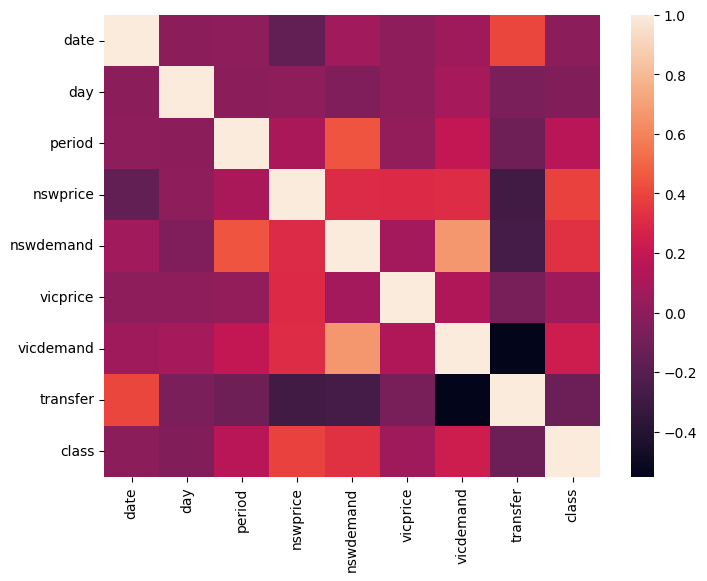

In [6]:
# correlation between the features and targets
plt.figure(figsize = (8, 6))
corr_df = pd.concat([train_inputs, train_targets], axis = 1)
corr_df = corr_df.corr()
sns.heatmap(corr_df)
plt.show()

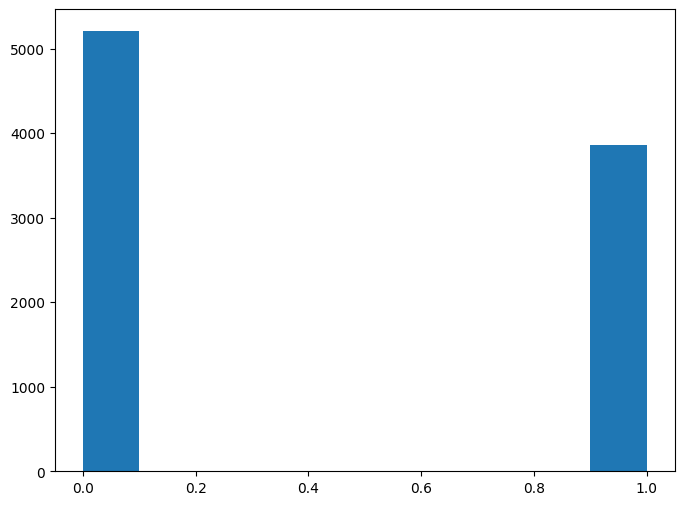

In [7]:
plt.figure(figsize = (8,6))
plt.hist(test_targets)
plt.show()

### Datasets and DataLoader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x,y

    def __len__(self):
        return self.data.shape[0]

EPSILON = 1e-12
# normalization of the input(min max normali)
norm_val_inputs = ((valid_inputs - valid_inputs.min()) / (valid_inputs.max() - valid_inputs.min()+EPSILON)).to_numpy()
norm_tst_inputs = ((test_inputs - test_inputs.min()) / (test_inputs.max() - test_inputs.min()+EPSILON)).to_numpy()
norm_train_inputs = ((train_inputs - train_inputs.min()) / (train_inputs.max() - train_inputs.min()+EPSILON)).to_numpy()

val_inputs, val_targets = valid_inputs.to_numpy(), valid_targets.to_numpy().reshape((-1,1))
tst_inputs, tst_targets = test_inputs.to_numpy(), test_targets.to_numpy().reshape((-1,1))
train_inputs, train_targets = train_inputs.to_numpy(), train_targets.to_numpy().reshape((-1,1))

train_dataset = CustomDataset(train_inputs, train_targets)
train_dataloader = DataLoader(
    dataset = train_dataset, 
    shuffle = True, 
    batch_size = 64
)

norm_train_dataset = CustomDataset(norm_train_inputs, train_targets)
norm_train_dataloader = DataLoader(
    dataset = norm_train_dataset, 
    shuffle = True, 
    batch_size = 64
)

## 1) Logistic Regression

In [9]:
lr = linear_model.LogisticRegression(random_state = SEED)
lr.fit(norm_train_inputs, train_targets)
test_preds = lr.predict(norm_tst_inputs)

test_acc_lr = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_lr = metrics.f1_score(tst_targets, test_preds)
# test_recall_lr = metrics.recall_score(tst_targets, test_preds)
# test_precision_lr = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_lr}")
# print(f"Test F1 score: {test_f1_lr}")
# print(f"Test Recall score: {test_recall_lr}")
# print(f"Test precision score: {test_precision_lr}")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 0.7484276729559748


## 2) Random Forest Classifier

  0%|                                                           | 0/11 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
  9%|████▋                                              | 1/11 [00:00<00:01,  6.99it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 18%|█████████▎                                         | 2/11 [00:00<00:02,  3.69it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d arra

Best n estimator with respect to Accuracy: 25


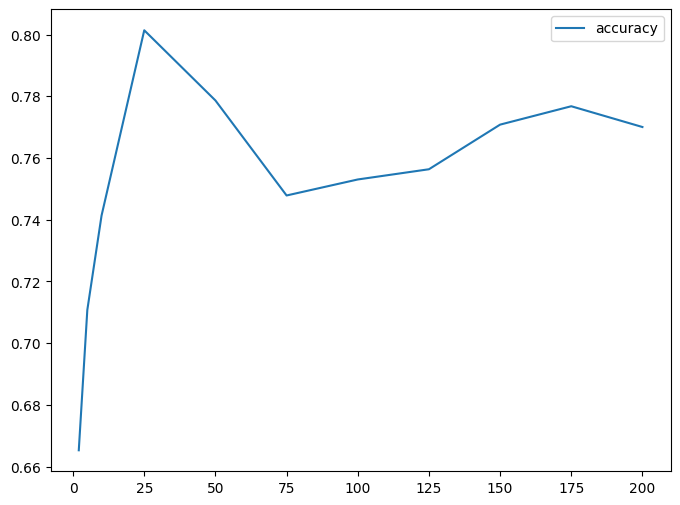

In [10]:
## hyperparameter tuning
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_accs = []
val_f1s = []
val_recalls = []
val_precisions = []

for num_est in tqdm(num_estimators):
    rf = ensemble.RandomForestClassifier(random_state = SEED, n_estimators = num_est)
    rf.fit(norm_train_inputs, train_targets)
    val_preds = rf.predict(norm_val_inputs)

    val_acc = metrics.accuracy_score(val_targets, val_preds)
    # val_f1 = metrics.f1_score(val_targets, val_preds)
    # val_recall = metrics.recall_score(val_targets, val_preds)
    # val_precision = metrics.precision_score(val_targets, val_preds)
    
    val_accs.append(val_acc)
    # val_f1s.append(val_f1)
    # val_recalls.append(val_recall)
    # val_precisions.append(val_precision)

best_n_estimator_acc = num_estimators[val_accs.index(max(val_accs))]
# best_n_estimator_f1 = num_estimators[val_f1s.index(max(val_f1s))]

print(f"Best n estimator with respect to Accuracy: {best_n_estimator_acc}")
# print(f"Best n estimator with respect to F1 Score: {best_n_estimator_f1}")

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_accs, label = 'accuracy')
# plt.plot(num_estimators, val_f1s, label = 'f1 score')
# plt.plot(num_estimators, val_recalls, label = 'recall')
# plt.plot(num_estimators, val_precisions, label = 'precision')
plt.legend()
plt.show()

In [11]:
rf = ensemble.RandomForestClassifier(random_state = SEED, n_estimators = best_n_estimator_acc)
rf.fit(norm_train_inputs, train_targets)
test_preds = rf.predict(norm_tst_inputs)

test_acc_rf = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_rf = metrics.f1_score(tst_targets, test_preds)
# test_recall_rf = metrics.recall_score(tst_targets, test_preds)
# test_precision_rf = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_rf}")
# print(f"Test F1 score: {test_f1_rf}")
# print(f"Test Recall score: {test_recall_rf}")
# print(f"Test precision score: {test_precision_rf}")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.8717863841994924


## 3) Tree Classifier

In [12]:
dtc = tree.DecisionTreeClassifier(random_state = SEED)
dtc.fit(norm_train_inputs, train_targets)

test_preds = dtc.predict(norm_tst_inputs)

test_acc_dtc = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_dtc = metrics.f1_score(tst_targets, test_preds)
# test_recall_dtc = metrics.recall_score(tst_targets, test_preds)
# test_precision_dtc = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_dtc}")
# print(f"Test F1 score: {test_f1_dtc}")
# print(f"Test Recall score: {test_recall_dtc}")
# print(f"Test precision score: {test_precision_dtc}")

Test Accuracy: 0.8280922431865828


## 4) XGBoost Classifier

100%|██████████████████████████████████████████████████| 11/11 [02:41<00:00, 14.66s/it]


Best n estimator with respect to Accuracy: 50


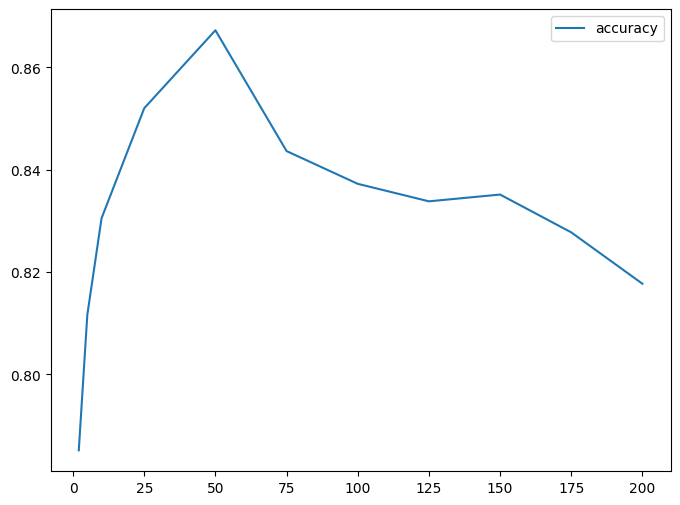

In [13]:
## hyperparameter tuning
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_accs = []
val_f1s = []
val_recalls = []
val_precisions = []

for num_est in tqdm(num_estimators):
    xgb = XGBClassifier(random_state = SEED, n_estimators = num_est)
    xgb.fit(norm_train_inputs, train_targets)
    val_preds = xgb.predict(norm_val_inputs)

    val_acc = metrics.accuracy_score(val_targets, val_preds)
    # val_f1 = metrics.f1_score(val_targets, val_preds)
    # val_recall = metrics.recall_score(val_targets, val_preds)
    # val_precision = metrics.precision_score(val_targets, val_preds)
    
    val_accs.append(val_acc)
    # val_f1s.append(val_f1)
    # val_recalls.append(val_recall)
    # val_precisions.append(val_precision)

best_n_estimator_acc = num_estimators[val_accs.index(max(val_accs))]
# best_n_estimator_f1 = num_estimators[val_f1s.index(max(val_f1s))]

print(f"Best n estimator with respect to Accuracy: {best_n_estimator_acc}")
# print(f"Best n estimator with respect to F1 Score: {best_n_estimator_f1}")

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_accs, label = 'accuracy')
# plt.plot(num_estimators, val_f1s, label = 'f1 score')
# plt.plot(num_estimators, val_recalls, label = 'recall')
# plt.plot(num_estimators, val_precisions, label = 'precision')
plt.legend()
plt.show()

In [14]:
xgb = XGBClassifier(random_state = SEED, n_estimators = best_n_estimator_acc)
xgb.fit(norm_train_inputs, train_targets)
test_preds = xgb.predict(norm_tst_inputs)

test_acc_xgb = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_xgb = metrics.f1_score(tst_targets, test_preds)
# test_recall_xgb = metrics.recall_score(tst_targets, test_preds)
# test_precision_xgb = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_xgb}")
# print(f"Test F1 score: {test_f1_xgb}")
# print(f"Test Recall score: {test_recall_xgb}")
# print(f"Test precision score: {test_precision_xgb}")

Test Accuracy: 0.8704623193203134


## 5) CatBoost Classifier

In [15]:
cat = CatBoostClassifier(random_state = SEED, n_estimators = best_n_estimator_acc)
cat.fit(norm_train_inputs, train_targets)
test_preds = cat.predict(norm_tst_inputs)

test_acc_cat = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_cat = metrics.f1_score(tst_targets, test_preds)
# test_recall_cat = metrics.recall_score(tst_targets, test_preds)
# test_precision_cat = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_cat}")
# print(f"Test F1 score: {test_f1_cat}")
# print(f"Test Recall score: {test_recall_cat}")
# print(f"Test precision score: {test_precision_cat}")

Learning rate set to 0.5
0:	learn: 0.5528561	total: 52ms	remaining: 2.55s
1:	learn: 0.4961239	total: 91.2ms	remaining: 2.19s
2:	learn: 0.4616446	total: 98ms	remaining: 1.53s
3:	learn: 0.4443042	total: 112ms	remaining: 1.29s
4:	learn: 0.4338925	total: 116ms	remaining: 1.04s
5:	learn: 0.4271171	total: 148ms	remaining: 1.09s
6:	learn: 0.4206661	total: 161ms	remaining: 988ms
7:	learn: 0.4137037	total: 174ms	remaining: 913ms
8:	learn: 0.4070881	total: 182ms	remaining: 827ms
9:	learn: 0.4011175	total: 184ms	remaining: 737ms
10:	learn: 0.3964852	total: 228ms	remaining: 808ms
11:	learn: 0.3921956	total: 231ms	remaining: 730ms
12:	learn: 0.3879326	total: 233ms	remaining: 663ms
13:	learn: 0.3857672	total: 235ms	remaining: 605ms
14:	learn: 0.3836437	total: 237ms	remaining: 554ms
15:	learn: 0.3815581	total: 240ms	remaining: 509ms
16:	learn: 0.3763879	total: 242ms	remaining: 470ms
17:	learn: 0.3743156	total: 244ms	remaining: 434ms
18:	learn: 0.3715756	total: 247ms	remaining: 403ms
19:	learn: 0.3689

## 6) LightGBM classifier

  0%|                                                           | 0/11 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11491, number of negative: 15696


/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


  9%|████▋                                              | 1/11 [00:03<00:32,  3.26s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 18%|█████████▎                                         | 2/11 [00:11<00:53,  6.00s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 27%|█████████████▉                                     | 3/11 [00:11<00:28,  3.59s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 36%|██████████████████▌                                | 4/11 [00:14<00:21,  3.07s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 45%|███████████████████████▏                           | 5/11 [00:18<00:21,  3.56s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 55%|███████████████████████████▊                       | 6/11 [00:27<00:26,  5.31s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 64%|████████████████████████████████▍                  | 7/11 [00:44<00:36,  9.18s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 73%|█████████████████████████████████████              | 8/11 [00:49<00:23,  7.88s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 82%|█████████████████████████████████████████▋         | 9/11 [00:56<00:15,  7.57s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


 91%|█████████████████████████████████████████████▍    | 10/11 [02:01<00:25, 25.19s/it]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842


100%|██████████████████████████████████████████████████| 11/11 [02:49<00:00, 15.45s/it]

Best n estimator with respect to Accuracy: 175


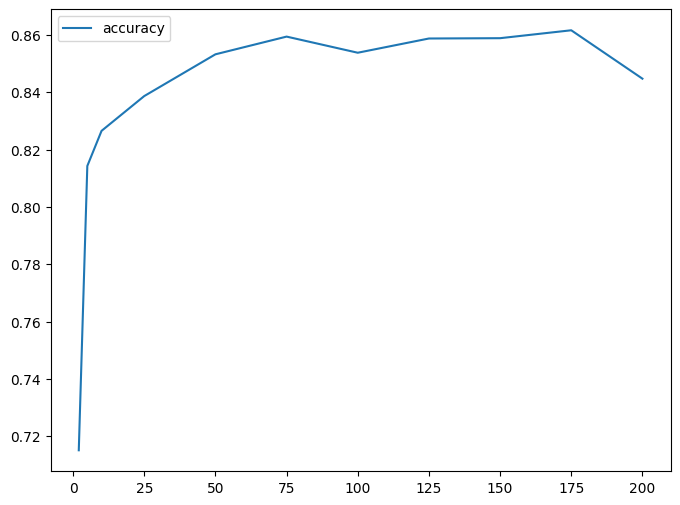

In [16]:
## hyperparameter tuning
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_accs = []
val_f1s = []
val_recalls = []
val_precisions = []

for num_est in tqdm(num_estimators):
    lgbm = LGBMClassifier(random_state = SEED, n_estimators = num_est)
    lgbm.fit(norm_train_inputs, train_targets)
    val_preds = lgbm.predict(norm_val_inputs)

    val_acc = metrics.accuracy_score(val_targets, val_preds)
    # val_f1 = metrics.f1_score(val_targets, val_preds)
    # val_recall = metrics.recall_score(val_targets, val_preds)
    # val_precision = metrics.precision_score(val_targets, val_preds)
    
    val_accs.append(val_acc)
    # val_f1s.append(val_f1)
    # val_recalls.append(val_recall)
    # val_precisions.append(val_precision)

best_n_estimator_acc = num_estimators[val_accs.index(max(val_accs))]
# best_n_estimator_f1 = num_estimators[val_f1s.index(max(val_f1s))]

print(f"Best n estimator with respect to Accuracy: {best_n_estimator_acc}")
# print(f"Best n estimator with respect to F1 Score: {best_n_estimator_f1}")

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_accs, label = 'accuracy')
# plt.plot(num_estimators, val_f1s, label = 'f1 score')
# plt.plot(num_estimators, val_recalls, label = 'recall')
# plt.plot(num_estimators, val_precisions, label = 'precision')
plt.legend()
plt.show()

In [17]:
lgbm = LGBMClassifier(random_state = SEED, n_estimators = best_n_estimator_acc)
lgbm.fit(norm_train_inputs, train_targets)
test_preds = lgbm.predict(norm_tst_inputs)

test_acc_lgbm = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_lgbm = metrics.f1_score(tst_targets, test_preds)
# test_recall_lgbm = metrics.recall_score(tst_targets, test_preds)
# test_precision_lgbm = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_lgbm}")
# print(f"Test F1 score: {test_f1_lgbm}")
# print(f"Test Recall score: {test_recall_lgbm}")
# print(f"Test precision score: {test_precision_lgbm}")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 11491, number of negative: 15696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 27187, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422665 -> initscore=-0.311842
[LightGBM] [Info] Start training from score -0.311842
Test Accuracy: 0.8788480635551142


## 7) GradientBoosting Classifier

  0%|                                                           | 0/11 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  9%|████▋                                              | 1/11 [00:00<00:01,  6.99it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 18%|█████████▎                                         | 2/11 [00:00<00:02,  3.87it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was pass

Best n estimator with respect to Accuracy: 200


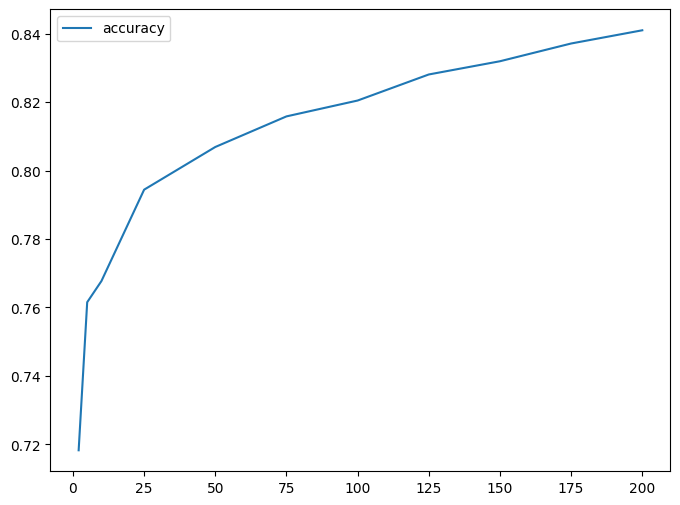

In [18]:
## hyperparameter tuning
num_estimators = [2, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200]
val_accs = []
val_f1s = []
val_recalls = []
val_precisions = []

for num_est in tqdm(num_estimators):
    gbc = ensemble.GradientBoostingClassifier(random_state = SEED, n_estimators = num_est)
    gbc.fit(norm_train_inputs, train_targets)
    val_preds = gbc.predict(norm_val_inputs)

    val_acc = metrics.accuracy_score(val_targets, val_preds)
    # val_f1 = metrics.f1_score(val_targets, val_preds)
    # val_recall = metrics.recall_score(val_targets, val_preds)
    # val_precision = metrics.precision_score(val_targets, val_preds)
    
    val_accs.append(val_acc)
    # val_f1s.append(val_f1)
    # val_recalls.append(val_recall)
    # val_precisions.append(val_precision)

best_n_estimator_acc = num_estimators[val_accs.index(max(val_accs))]
# best_n_estimator_f1 = num_estimators[val_f1s.index(max(val_f1s))]

print(f"Best n estimator with respect to Accuracy: {best_n_estimator_acc}")
# print(f"Best n estimator with respect to F1 Score: {best_n_estimator_f1}")

plt.figure(figsize = (8,6))
plt.plot(num_estimators, val_accs, label = 'accuracy')
# plt.plot(num_estimators, val_f1s, label = 'f1 score')
# plt.plot(num_estimators, val_recalls, label = 'recall')
# plt.plot(num_estimators, val_precisions, label = 'precision')
plt.legend()
plt.show()

In [19]:
gbc = ensemble.GradientBoostingClassifier(random_state = SEED, n_estimators = best_n_estimator_acc)
gbc.fit(norm_train_inputs, train_targets)
test_preds = gbc.predict(norm_tst_inputs)

test_acc_gbc = metrics.accuracy_score(tst_targets, test_preds)
# test_f1_gbc = metrics.f1_score(tst_targets, test_preds)
# test_recall_gbc = metrics.recall_score(tst_targets, test_preds)
# test_precision_gbc = metrics.precision_score(tst_targets, test_preds)

print(f"Test Accuracy: {test_acc_gbc}")
# print(f"Test F1 score: {test_f1_gbc}")
# print(f"Test Recall score: {test_recall_gbc}")
# print(f"Test precision score: {test_precision_gbc}")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 0.8447533929162528


## 8) Vanilla Neural Network

In [20]:
lrs = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-2, 5e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

hyp_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        model = net(val_inputs.shape[1], [32, 32, 32, 8], num_classes, task = 'clf').to(device)
        model, train_losses, val_losses = train_net(model, norm_train_dataloader, val_inputs, val_targets, device, epochs = 5, lr = lrs[i], wd = wds[j])
        hyp_losses[i, j] += eval_net(model, norm_val_inputs, val_targets, device)
        print(f"{i * len(wds) + j + 1} / {len(lrs) * len(wds)}) Lr: {lrs[i]} Wds: {wds[j]}")
        print(f"Validation Loss: {hyp_losses[i,j]}")
        
best_lr, best_wd = np.unravel_index(np.argmax(hyp_losses), hyp_losses.shape)
print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")

  0%|                                                            | 0/5 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:222: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


1 / 48) Lr: 0.001 Wds: 1e-05
Validation Loss: 0.7559037740013242


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


2 / 48) Lr: 0.001 Wds: 0.0005
Validation Loss: 0.7785257117634077


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


3 / 48) Lr: 0.001 Wds: 0.0001
Validation Loss: 0.765393952769808


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


4 / 48) Lr: 0.001 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


5 / 48) Lr: 0.001 Wds: 0.001
Validation Loss: 0.7755462370337673


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


6 / 48) Lr: 0.001 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


7 / 48) Lr: 0.005 Wds: 1e-05
Validation Loss: 0.7450893842418892


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


8 / 48) Lr: 0.005 Wds: 0.0005
Validation Loss: 0.7716839549768263


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


9 / 48) Lr: 0.005 Wds: 0.0001
Validation Loss: 0.7741116751269036


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


10 / 48) Lr: 0.005 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


11 / 48) Lr: 0.005 Wds: 0.001
Validation Loss: 0.7678216729198852


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


12 / 48) Lr: 0.005 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


13 / 48) Lr: 0.0001 Wds: 1e-05
Validation Loss: 0.6676230412712425


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


14 / 48) Lr: 0.0001 Wds: 0.0005
Validation Loss: 0.6504082983888766


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


15 / 48) Lr: 0.0001 Wds: 0.0001
Validation Loss: 0.6636504082983888


100%|████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


16 / 48) Lr: 0.0001 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


17 / 48) Lr: 0.0001 Wds: 0.001
Validation Loss: 0.6370558375634517


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


18 / 48) Lr: 0.0001 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


19 / 48) Lr: 0.0005 Wds: 1e-05
Validation Loss: 0.7701390421540498


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


20 / 48) Lr: 0.0005 Wds: 0.0005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


21 / 48) Lr: 0.0005 Wds: 0.0001
Validation Loss: 0.7574486868241006


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


22 / 48) Lr: 0.0005 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


23 / 48) Lr: 0.0005 Wds: 0.001
Validation Loss: 0.7626351798719929


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


24 / 48) Lr: 0.0005 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


25 / 48) Lr: 1e-05 Wds: 1e-05
Validation Loss: 0.4292650629000221


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


26 / 48) Lr: 1e-05 Wds: 0.0005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


27 / 48) Lr: 1e-05 Wds: 0.0001
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


28 / 48) Lr: 1e-05 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


29 / 48) Lr: 1e-05 Wds: 0.001
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


30 / 48) Lr: 1e-05 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


31 / 48) Lr: 5e-05 Wds: 1e-05
Validation Loss: 0.5988744206576915


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


32 / 48) Lr: 5e-05 Wds: 0.0005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


33 / 48) Lr: 5e-05 Wds: 0.0001
Validation Loss: 0.6179651291105717


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


34 / 48) Lr: 5e-05 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


35 / 48) Lr: 5e-05 Wds: 0.001
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


36 / 48) Lr: 5e-05 Wds: 0.05
Validation Loss: 0.4292650629000221


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


37 / 48) Lr: 0.01 Wds: 1e-05
Validation Loss: 0.7548002648421982


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


38 / 48) Lr: 0.01 Wds: 0.0005
Validation Loss: 0.7723460604723019


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


39 / 48) Lr: 0.01 Wds: 0.0001
Validation Loss: 0.7399028911939969


100%|████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


40 / 48) Lr: 0.01 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


41 / 48) Lr: 0.01 Wds: 0.001
Validation Loss: 0.7103288457294196


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


42 / 48) Lr: 0.01 Wds: 0.05
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


43 / 48) Lr: 0.05 Wds: 1e-05
Validation Loss: 0.4292650629000221


100%|████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.05s/it]


44 / 48) Lr: 0.05 Wds: 0.0005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


45 / 48) Lr: 0.05 Wds: 0.0001
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.05s/it]


46 / 48) Lr: 0.05 Wds: 0.005
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


47 / 48) Lr: 0.05 Wds: 0.001
Validation Loss: 0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]

48 / 48) Lr: 0.05 Wds: 0.05
Validation Loss: 0.5707349370999779
Best LR: 0.001 Best WD: 0.0005


In [21]:
model = net(val_inputs.shape[1], [32, 32, 32, 8], num_classes, task = 'clf').to(device)
model, train_losses, val_losses = train_net(model, norm_train_dataloader, val_inputs, val_targets, device, lr = lrs[best_lr], wd = wds[best_wd])
test_acc_mlp = eval_net(model, norm_tst_inputs, tst_targets, device)
print(test_acc_mlp)

100%|██████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]

0.7680679686637979


## 9) SiFer Classification

In [ ]:
forget_lrs = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-2, 5e-2]
forget_iters = [2,5]
lrs = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-2, 5e-2]

hyp_losses = np.zeros((len(forget_iters), len(forget_lrs), len(lrs)))

for i in range(len(forget_iters)):
    for j in range(len(forget_lrs)):
        for k in range(len(lrs)):
            model = SiFer_Class([32, 32, 32, 8], [8, 8], 1, num_features, num_classes).to(device)
            model, train_losses, val_losses = train_class(model, norm_train_dataloader, val_inputs, val_targets, num_classes,  forget_iters = forget_iters[i], lrs = [lrs[k], lrs[k], forget_lrs[j]], epochs = 5)
            hyp_losses[i, j, k] += eval_fsclass(model, norm_val_inputs, val_targets)
            print(f"[{i*(len(forget_lrs) * len(lrs)) + j*(len(lrs)) + k + 1} / {len(forget_lrs) * len(lrs)* len(forget_iters)}] LR: {lrs[k]} Forget Lr: {forget_lrs[j]} Forget Iter: {forget_iters[i]}")
            print(hyp_losses[i,j,k])
            
best_forget_iter, best_forget_lr, best_lr = np.unravel_index(np.argmax(hyp_losses), hyp_losses.shape)
print(f"Best Forget Iter: {forget_iters[best_forget_iter]} Best Forget Lr: {forget_lrs[best_forget_lr]} Best Lr: {lrs[best_lr]}")

100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.40s/it]


[1 / 128] LR: 0.001 Forget Lr: 0.001 Forget Iter: 2
0.7416685058485986


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


[2 / 128] LR: 0.005 Forget Lr: 0.001 Forget Iter: 2
0.7338335908188038


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


[3 / 128] LR: 0.0001 Forget Lr: 0.001 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.47s/it]


[4 / 128] LR: 0.0005 Forget Lr: 0.001 Forget Iter: 2
0.6011917898918561


100%|████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.50s/it]


[5 / 128] LR: 1e-05 Forget Lr: 0.001 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.84s/it]


[6 / 128] LR: 5e-05 Forget Lr: 0.001 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


[7 / 128] LR: 0.01 Forget Lr: 0.001 Forget Iter: 2
0.7640697417788568


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


[8 / 128] LR: 0.05 Forget Lr: 0.001 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.44s/it]


[9 / 128] LR: 0.001 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


[10 / 128] LR: 0.005 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.38s/it]


[11 / 128] LR: 0.0001 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.53s/it]


[12 / 128] LR: 0.0005 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


[13 / 128] LR: 1e-05 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


[14 / 128] LR: 5e-05 Forget Lr: 0.005 Forget Iter: 2
0.6283381152063562


100%|████████████████████████████████████████████████████| 5/5 [00:24<00:00,  5.00s/it]


[15 / 128] LR: 0.01 Forget Lr: 0.005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.61s/it]


[16 / 128] LR: 0.05 Forget Lr: 0.005 Forget Iter: 2
0.6569190024277202


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


[17 / 128] LR: 0.001 Forget Lr: 0.0001 Forget Iter: 2
0.7134186713749724


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


[18 / 128] LR: 0.005 Forget Lr: 0.0001 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


[19 / 128] LR: 0.0001 Forget Lr: 0.0001 Forget Iter: 2
0.6601191789891856


100%|████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.97s/it]


[20 / 128] LR: 0.0005 Forget Lr: 0.0001 Forget Iter: 2
0.719929375413816


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


[21 / 128] LR: 1e-05 Forget Lr: 0.0001 Forget Iter: 2
0.4256234826749062


100%|████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.26s/it]


[22 / 128] LR: 5e-05 Forget Lr: 0.0001 Forget Iter: 2
0.5715073935113661


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


[23 / 128] LR: 0.01 Forget Lr: 0.0001 Forget Iter: 2
0.7205914809092916


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]


[24 / 128] LR: 0.05 Forget Lr: 0.0001 Forget Iter: 2
0.7290885014345619


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.69s/it]


[25 / 128] LR: 0.001 Forget Lr: 0.0005 Forget Iter: 2
0.7382476274553079


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.60s/it]


[26 / 128] LR: 0.005 Forget Lr: 0.0005 Forget Iter: 2
0.6774442727874641


100%|████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.07s/it]


[27 / 128] LR: 0.0001 Forget Lr: 0.0005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


[28 / 128] LR: 0.0005 Forget Lr: 0.0005 Forget Iter: 2
0.7182741116751269


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.40s/it]


[29 / 128] LR: 1e-05 Forget Lr: 0.0005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


[30 / 128] LR: 5e-05 Forget Lr: 0.0005 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


[31 / 128] LR: 0.01 Forget Lr: 0.0005 Forget Iter: 2
0.7535864047671595


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]


[32 / 128] LR: 0.05 Forget Lr: 0.0005 Forget Iter: 2
0.5986537188258663


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


[33 / 128] LR: 0.001 Forget Lr: 1e-05 Forget Iter: 2
0.7047009490178768


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


[34 / 128] LR: 0.005 Forget Lr: 1e-05 Forget Iter: 2
0.7774222026042816


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


[35 / 128] LR: 0.0001 Forget Lr: 1e-05 Forget Iter: 2
0.646987419995586


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]


[36 / 128] LR: 0.0005 Forget Lr: 1e-05 Forget Iter: 2
0.7400132421099095


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


[37 / 128] LR: 1e-05 Forget Lr: 1e-05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.60s/it]


[38 / 128] LR: 5e-05 Forget Lr: 1e-05 Forget Iter: 2
0.6234826749062017


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.37s/it]


[39 / 128] LR: 0.01 Forget Lr: 1e-05 Forget Iter: 2
0.7182741116751269


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


[40 / 128] LR: 0.05 Forget Lr: 1e-05 Forget Iter: 2
0.7229088501434562


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.61s/it]


[41 / 128] LR: 0.001 Forget Lr: 5e-05 Forget Iter: 2
0.7469653498124035


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


[42 / 128] LR: 0.005 Forget Lr: 5e-05 Forget Iter: 2
0.7553520194217612


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.45s/it]


[43 / 128] LR: 0.0001 Forget Lr: 5e-05 Forget Iter: 2
0.6125579342308541


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.64s/it]


[44 / 128] LR: 0.0005 Forget Lr: 5e-05 Forget Iter: 2
0.7533657029353343


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.54s/it]


[45 / 128] LR: 1e-05 Forget Lr: 5e-05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


[46 / 128] LR: 5e-05 Forget Lr: 5e-05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.41s/it]


[47 / 128] LR: 0.01 Forget Lr: 5e-05 Forget Iter: 2
0.7520414919443832


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.44s/it]


[48 / 128] LR: 0.05 Forget Lr: 5e-05 Forget Iter: 2
0.5715073935113661


100%|████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.06s/it]


[49 / 128] LR: 0.001 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.70s/it]


[50 / 128] LR: 0.005 Forget Lr: 0.01 Forget Iter: 2
0.5787905539615978


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


[51 / 128] LR: 0.0001 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


[52 / 128] LR: 0.0005 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.83s/it]


[53 / 128] LR: 1e-05 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


[54 / 128] LR: 5e-05 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


[55 / 128] LR: 0.01 Forget Lr: 0.01 Forget Iter: 2
0.6675126903553299


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


[56 / 128] LR: 0.05 Forget Lr: 0.01 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


[57 / 128] LR: 0.001 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.37s/it]


[58 / 128] LR: 0.005 Forget Lr: 0.05 Forget Iter: 2
0.7210328845729419


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


[59 / 128] LR: 0.0001 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


[60 / 128] LR: 0.0005 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


[61 / 128] LR: 1e-05 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


[62 / 128] LR: 5e-05 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]


[63 / 128] LR: 0.01 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.57s/it]


[64 / 128] LR: 0.05 Forget Lr: 0.05 Forget Iter: 2
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


[65 / 128] LR: 0.001 Forget Lr: 0.001 Forget Iter: 5
0.7661664091811962


100%|████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.94s/it]


[66 / 128] LR: 0.005 Forget Lr: 0.001 Forget Iter: 5
0.7136393732067976


100%|████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


[67 / 128] LR: 0.0001 Forget Lr: 0.001 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


[68 / 128] LR: 0.0005 Forget Lr: 0.001 Forget Iter: 5
0.7445376296623262


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


[69 / 128] LR: 1e-05 Forget Lr: 0.001 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]


[70 / 128] LR: 5e-05 Forget Lr: 0.001 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


[71 / 128] LR: 0.01 Forget Lr: 0.001 Forget Iter: 5
0.7205914809092916


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.24s/it]


[72 / 128] LR: 0.05 Forget Lr: 0.001 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


[73 / 128] LR: 0.001 Forget Lr: 0.005 Forget Iter: 5
0.5924740675347605


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.04s/it]


[74 / 128] LR: 0.005 Forget Lr: 0.005 Forget Iter: 5
0.7635179871992938


100%|████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


[75 / 128] LR: 0.0001 Forget Lr: 0.005 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.99s/it]


[76 / 128] LR: 0.0005 Forget Lr: 0.005 Forget Iter: 5
0.6073714411829618


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


[77 / 128] LR: 1e-05 Forget Lr: 0.005 Forget Iter: 5
0.5707349370999779


100%|████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.04s/it]


[78 / 128] LR: 5e-05 Forget Lr: 0.005 Forget Iter: 5
0.5707349370999779


 80%|█████████████████████████████████████████▌          | 4/5 [00:17<00:04,  4.44s/it]

In [ ]:
model = SiFer_Class([32, 32, 32, 8], [8, 8], 1, num_features, num_classes).to(device)
model, train_losses, val_losses = train_class(model, norm_train_dataloader, val_inputs, val_targets, num_classes, forget_iters = forget_iters[best_forget_iter], lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[best_forget_lr]])
test_acc_sifer = eval_fsclass(model, norm_tst_inputs, tst_targets)
print(test_acc_sifer)

## Visualization 

In [ ]:
def bar_plot(data, xlabel, ylabel, title, name):
    x = list(data.keys())
    y = list(data.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    # Create the bar plot
    ax.bar(x, y, color ='maroon', width = 0.4)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y = 0.5, linestyle = '--', color = 'black')
    # Display the values on top of the bars
    plt.xticks(rotation = 45)
    for i, v in enumerate(y):
        ax.text(i, v + 0.005 if v> 0 else v-5, '{:.4f}'.format(v), color='black', ha='center')
        
    plt.savefig(f"./Outputs/Classification/{name}.png")

In [ ]:
dict_ = {
    "Logistic Regression":test_acc_lr,
    "Decision Tree Classifier":test_acc_dtc,
    "Random Forest Classifier": test_acc_rf,
    "XGBoost Classifier": test_acc_xgb, 
    "Gradient Boosting Classifier": test_acc_gbc, 
    "CatBoost Classifier": test_acc_cat, 
    "LightGBM Classifier": test_acc_lgbm, 
    "Neural Network": test_acc_mlp, 
    "SiFer Classification": test_acc_sifer, 
}
bar_plot(dict_, f"{dataset_name}", df['target_names'][0] + " Accuracy", f"Tabular Dataset Comparison ({dataset_name})", f'tab-data-{dataset_name}-accuracy')

In [ ]:
results_df = pd.DataFrame(dict_.values(), index = dict_.keys(), columns = [df['target_names'][0] + "-Accuracy"])
results_df[df['target_names'][0] + '-Accuracy'] = results_df[df['target_names'][0] + '-Accuracy'].apply(lambda x: float(x))
results_df.to_csv(f"./Outputs/Classification/tab-data-{dataset_name}-accuracy.csv")
results_df